In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from paths import get_project_path
from statistics import mean, median

In [2]:
def parse_file(path_file):
    with open(path_file, 'rb') as f:
        data = f.readlines()
    voltage_list = []
    current_list = []
    for number, string in enumerate(data[8:]):
        clean_string = str(str(string).split("'")[1]).rstrip().strip().replace("\\n", '')
        voltage = clean_string.split(',')[0]
        current = clean_string.split(',')[1]
        voltage_list.append(float(voltage))
        current_list.append(float(current))
    tables, last_index = [], 0
    for i in range(len(voltage_list)):
        if (voltage_list[i] == 1.0) & (i != 0):
            tables.append(pd.DataFrame({'current': current_list[last_index:i],
                                        'voltage': voltage_list[last_index:i]}))
            last_index = i
    return tables

In [3]:
all_tables = []
all_labels = []
all_names = []
dir_path = os.path.join(get_project_path(), 'data', 'external', 'generated_dataset_version_1')
for file in tqdm(os.listdir(dir_path)):
    if file.endswith('all_solutions.txt'):
        low_conc = float(file.split("_")[1])
        high_conc = float(file.split("_")[2])
        for amount, one in enumerate(parse_file(os.path.join(dir_path, file))):
            all_tables.append(one)
        range_conc = np.linspace(low_conc, high_conc, num=amount + 1)
        for conc in range_conc:
            all_labels.append(conc)
print(len(all_tables))
print(len(all_labels))

100%|██████████| 13/13 [00:02<00:00,  4.99it/s]

6993
6993


In [4]:
lengths = []
for table in all_tables:
    if len(table) == 239:
        MINIMUM = table
    if len(table) == 280:
        MAXIMUM = table
    lengths.append(len(table))
max(lengths), min(lengths)

(280, 212)

237


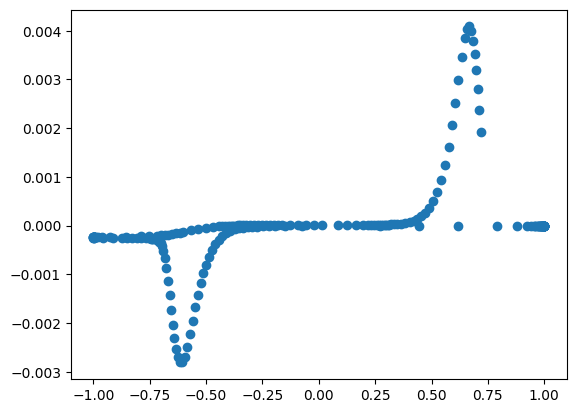

In [5]:
one = all_tables[2000]
slice = 200
print(len(one))
plt.scatter(one['voltage'][:slice], one['current'][:slice])

# Interpolation

In [6]:
from scipy.interpolate import interp1d


def interpolation_for_cycle(df: pd.DataFrame, plot=False):
    difference = max(lengths) - len(df)
    if difference == 0:
        return df
    else:
        df = df.drop_duplicates(subset=['voltage'])
        current = df.current.tolist()
        voltage = df.voltage.tolist()
        need_current = [x for x in current if x > mean(current) + 0.0001]
        need_voltage = [voltage[current.index(vol)] for vol in need_current]
        cubic_interpolate_function = interp1d(need_voltage, need_current, kind='cubic')
        x_new = np.linspace(need_voltage[0], need_voltage[-1], num=difference + 2, endpoint=True)
        start_index = voltage.index(need_voltage[0])
        end_index = voltage.index(need_voltage[-1])
        y_new = cubic_interpolate_function(x_new)
        if plot:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.plot(voltage, current)
            plt.scatter(need_voltage[0], current[start_index], c='r', s=70)
            plt.scatter(need_voltage[-1], current[end_index], c='r', s=70)
        for volt, curr in zip(x_new, y_new):
            voltage.insert(start_index, volt)
            current.insert(start_index, curr)
            start_index += 1
            end_index += 1

        if plot:
            plt.subplot(1, 2, 2)
            plt.scatter(voltage, current, c='y')
            plt.plot(x_new, y_new, c='r')
            plt.show()
        return pd.DataFrame(data={'voltage': voltage, 'current': current}).sort_values(by='voltage')

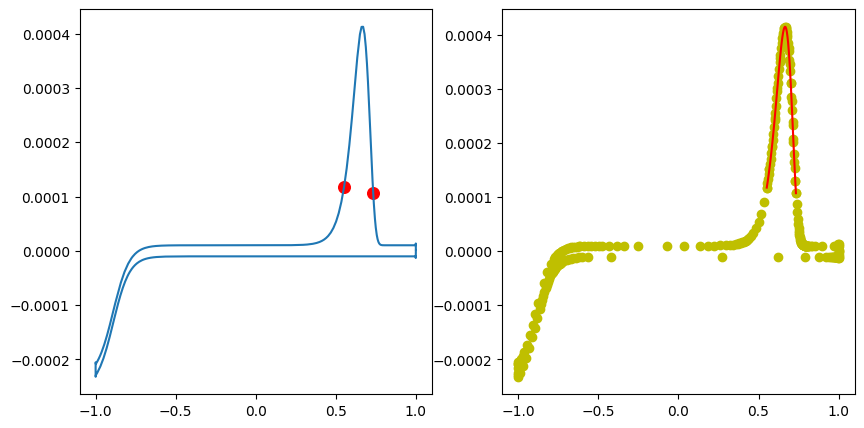

,voltage,current
81,-0.999977,-2.152269e-04
80,-0.999954,-2.253354e-04
82,-0.999783,-2.078572e-04
79,-0.999697,-2.320999e-04
83,-0.999473,-2.053714e-04
...,...,...
279,0.999887,8.818808e-06
2,0.999936,-6.842318e-06
280,0.999991,2.642918e-06
1,0.999993,-2.378650e-06


In [7]:
interpolation_for_cycle(all_tables[0], plot=True)

In [8]:
result_rows = []
for num, table in enumerate(tqdm(all_tables)):
    try:
        result_rows.append(interpolation_for_cycle(table)['current'])
    except Exception as error:
        print(error)
result = pd.DataFrame(data=result_rows)
result

100%|██████████| 6993/6993 [03:16<00:00, 35.66it/s]


,81,80,82,79,83,84,78,85,86,87,...,277,5,278,4,3,279,2,280,1,0
current,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000209,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24
current,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24
current,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24
current,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24
current,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
current,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24
current,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24
current,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24
current,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24


# Dataset

In [9]:
result.columns = list(range(1, len(result.columns) + 1))
result.index = range(1, (len(result) + 1))
result['concentration'] = all_labels
result

,1,2,3,4,5,6,7,8,9,10,...,273,274,275,276,277,278,279,280,281,concentration
1,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000209,-0.000208,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24,1.000000e-07
2,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24,9.990982e-08
3,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24,9.981964e-08
4,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24,9.972946e-08
5,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584791e-24,9.963928e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24,1.036072e-02
6990,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24,1.027054e-02
6991,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24,1.018036e-02
6992,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,-2.584985e-24,1.009018e-02


In [10]:
result[280].info(memory_usage="deep"), result['concentration'].info(memory_usage="deep")

<class 'pandas.core.series.Series'>
RangeIndex: 6993 entries, 1 to 6993
Series name: 280
Non-Null Count  Dtype  
--------------  -----  
6993 non-null   float64
dtypes: float64(1)
memory usage: 54.8 KB
<class 'pandas.core.series.Series'>
RangeIndex: 6993 entries, 1 to 6993
Series name: concentration
Non-Null Count  Dtype  
--------------  -----  
6993 non-null   float64
dtypes: float64(1)
memory usage: 54.8 KB


(None, None)

In [11]:
result.isnull().sum().sum()

4

In [12]:
result.dropna(inplace=True)

In [ ]:
result.to_csv("dataset.csv")

# Model fitting

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

In [2]:
result = pd.read_csv('dataset.csv', index_col=[0])
result.drop(columns='281', axis=1)

,1,2,3,4,5,6,7,8,9,10,...,272,273,274,275,276,277,278,279,280,concentration
1,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000209,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,1.000000e-07
2,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,9.990982e-08
3,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,9.981964e-08
4,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,9.972946e-08
5,-0.000215,-0.000225,-0.000208,-0.000232,-0.000205,-0.000208,-0.000229,-0.000209,-0.000208,-0.000208,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,9.963928e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,1.036072e-02
6990,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,1.027054e-02
6991,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,1.018036e-02
6992,-0.000283,-0.000291,-0.000278,-0.000305,-0.000274,-0.000271,-0.000328,-0.000269,-0.000265,-0.000262,...,0.000013,-0.000013,0.000013,-0.000013,-0.00001,0.000009,-0.000007,0.000003,-0.000002,1.009018e-02


In [3]:
X_data = result.drop('concentration', axis=1)
y_data = result['concentration']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [4]:
model_Linear = LinearRegression()

In [5]:
model_Linear.fit(X_train, y_train)
pred_train_Linear = model_Linear.predict(X_train)
pred_test_Linear = model_Linear.predict(X_test)
print(f'R2 score for LinearRegression =  {r2_score(y_train, pred_train_Linear)}')
print(f'R2 score for LinearRegression = {r2_score(y_test, pred_test_Linear)}')

R2 score for LinearRegression =  0.9730915391876971
R2 score for LinearRegression = 0.971613853212797


In [6]:
model_Lasso = Lasso()
model_Lasso.fit(X_train,y_train)

pred_train_Lasso = model_Lasso.predict(X_train)
pred_test_Lasso = model_Lasso.predict(X_test)
print(f'R2 score for Lasso =  {r2_score(y_train,pred_train_Lasso)}')
print(f'R2 score for Lasso =  {r2_score(y_test, pred_test_Lasso)}')

R2 score for Lasso =  0.0
R2 score for Lasso =  -7.71601824793855e-05


In [7]:
model_Ridge = Ridge()
model_Ridge.fit(X_train,y_train)

pred_train_Ridge = model_Ridge.predict(X_train)
pred_test_Ridge = model_Ridge.predict(X_test)
print(f'R2 score for Ridge =  {r2_score(y_train,pred_train_Ridge)}')
print(f'R2 score for Ridge =  {r2_score(y_test, pred_test_Ridge)}')

R2 score for Ridge =  0.18222483985278115
R2 score for Ridge =  0.18004740378562079


In [8]:
model_SVR = SVR()
model_SVR.fit(X_train,y_train)

pred_train_SVR = model_SVR.predict(X_train)
pred_test_SVR = model_SVR.predict(X_test)
print(f'R2 score for SVR =  {r2_score(y_train,pred_train_SVR)}')
print(f'R2 score for SVR =  {r2_score(y_test, pred_test_SVR)}')

R2 score for SVR =  -3.7575034934850624
R2 score for SVR =  -3.5622774882727164


In [9]:
model_DecisionTree = DecisionTreeRegressor()
model_DecisionTree.fit(X_train,y_train)

pred_train_DecisionTree = model_DecisionTree.predict(X_train)
pred_test_DecisionTree = model_DecisionTree.predict(X_test)
print(f'R2 score for DecisionTree =  {r2_score(y_train,pred_train_DecisionTree)}')
print(f'R2 score for DecisionTree =  {r2_score(y_test, pred_test_DecisionTree)}')

R2 score for DecisionTree =  0.9974275967394044
R2 score for DecisionTree =  0.9974893634222682


In [10]:
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)

pred_train_RF = model_RF.predict(X_train)
pred_test_RF = model_RF.predict(X_test)
print(f'R2 score for RandomForest =  {r2_score(y_train,pred_train_RF)}')
print(f'R2 score for RandomForest =  {r2_score(y_test, pred_test_RF)}')

R2 score for RandomForest =  0.9999896265264449
R2 score for RandomForest =  0.9999900014421625


In [11]:
model_MLP = MLPRegressor()
model_MLP.fit(X_train, y_train)

pred_train_MLP = model_MLP.predict(X_train)
pred_test_MLP = model_MLP.predict(X_test)
print(f'R2 score for MLP =  {r2_score(y_train,pred_train_MLP)}')
print(f'R2 score for MLP =  {r2_score(y_test, pred_test_MLP)}')

R2 score for MLP =  0.8171696235976096
R2 score for MLP =  0.8024132051403535


In [12]:
model_KNN = KNeighborsRegressor()
model_KNN.fit(X_train, y_train)

pred_train_KNN = model_KNN.predict(X_train)
pred_test_KNN = model_KNN.predict(X_test)
print(f'R2 score for KNN =  {r2_score(y_train,pred_train_KNN)}')
print(f'R2 score for KNN =  {r2_score(y_test, pred_test_KNN)}')

R2 score for KNN =  0.9999979064209061
R2 score for KNN =  0.9999952379343245


In [13]:
model_KNN = KNeighborsRegressor()
model_KNN.fit(X_train, y_train)

pred_train_KNN = model_KNN.predict(X_train)
pred_test_KNN = model_KNN.predict(X_test)
print(f'R2 score for KNN =  {r2_score(y_train,pred_train_KNN)}')
print(f'R2 score for KNN =  {r2_score(y_test, pred_test_KNN)}')

R2 score for KNN =  0.9999979064209061
R2 score for KNN =  0.9999952379343245
